In order to simulate a realistic scenario, where labels are unavailable, in order to model the problem of detecting cyber attacks the target labels will not be used during modelling and they will only be used for the final evaluation.

In [4]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from intrusion_detection.load_input_data import load_df
from intrusion_detection.preprocessing.preprocessing import remove_dot_from_attack_type_classes
from intrusion_detection.target_definition import define_target
from intrusion_detection.preprocessing.pipeline import get_preprocessing_pipeline

In [20]:
df = load_df(
    file_path="../../../data/kddcup.data_10_percent",
    header_file="../../../data/kddcup.names"
)
df = remove_dot_from_attack_type_classes(df)

In [21]:
from sklearn.pipeline import Pipeline
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS

df_target = define_target(df)
preprocessing_pipeline = get_preprocessing_pipeline()
iforest_pipeline = Pipeline([*preprocessing_pipeline.steps, ("model", IForest(n_jobs=-1))])
hbos_pipeline = Pipeline([*preprocessing_pipeline.steps, ("model", HBOS())])

In [22]:
target_columns = [col for col in df_target.columns if "target" in col]
X = df_target.drop(target_columns, axis=1)
y = df_target["target_anomaly"]

In [ ]:
from sklearn.model_selection import cross_val_predict
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    iforest_preds = cross_val_predict(iforest_pipeline, X, cv=10, method="predict_proba")

In [27]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    hbos_preds = cross_val_predict(hbos_pipeline, X, cv=10, method="predict_proba")

<AxesSubplot: ylabel='Count'>

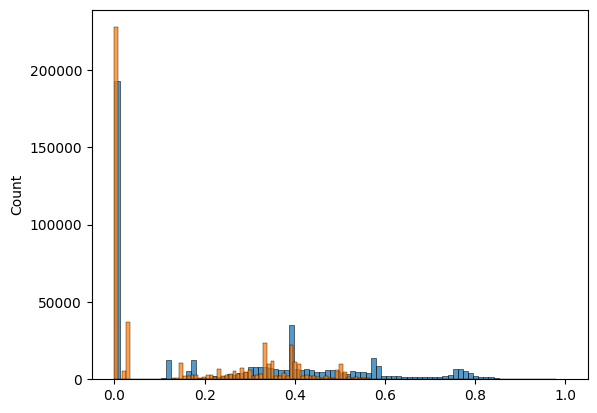

In [31]:
sns.histplot(iforest_preds[:,1])
sns.histplot(hbos_preds[:,1])

Determine threshold by using 2% percentile

In [42]:
import numpy as np
iforest_thr = np.percentile(iforest_preds[:,1], 98)
hbos_thr = np.percentile(hbos_preds[:,1], 98)

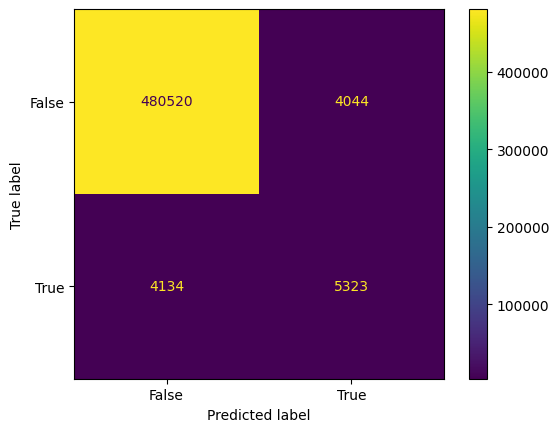

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   iforest_preds[:,1] > iforest_thr, hbos_preds[:,1] > hbos_thr
)


We notice that the two models agree on most instances being not anomalies. They agree on 5k instances being outliers and they disagree on about 8k instances. It can make sense to ensemble those two models using a voting ensemble.

In [44]:
ensembled_preds = (iforest_preds[:,1] + hbos_preds[:,1]) / 2
ensembled_thr = np.percentile(ensembled_preds, 98)

# Model Evaluation

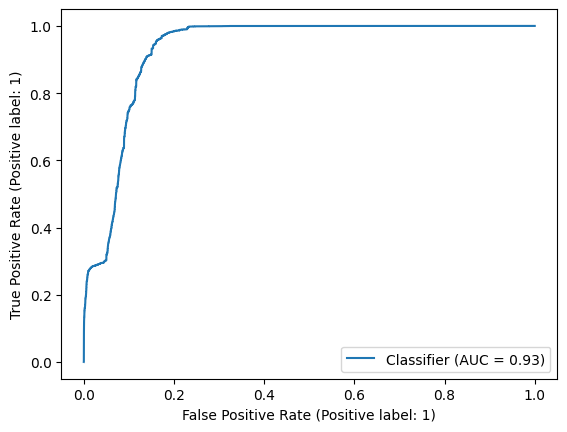

In [47]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_predictions(y, ensembled_preds)

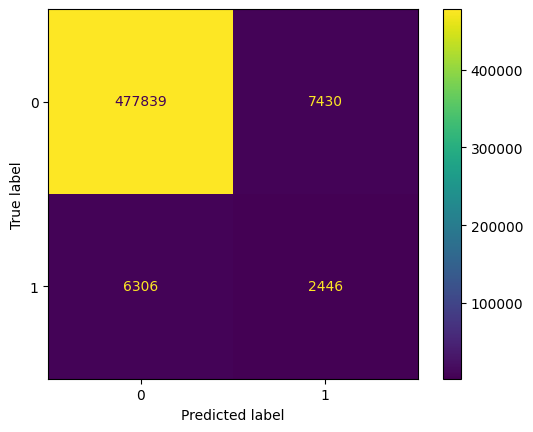

In [49]:
ConfusionMatrixDisplay.from_predictions(
   y, ensembled_preds > ensembled_thr
)


In [81]:
prediction_by_attack_type = pd.DataFrame({"attack_type": df.attack_type.values, "classified_as_anomaly": (ensembled_preds > ensembled_thr).astype(int)})

In [79]:
attack_anomaly_counts = pd.DataFrame(prediction_by_attack_type.value_counts()).rename(columns={0: "cross_counts"}).reset_index()
attack_counts = pd.DataFrame(prediction_by_attack_type.attack_type.value_counts()).rename(columns={"attack_type": "attack_counts"}).reset_index().rename(columns={"index": "attack_type"})
merged = attack_anomaly_counts.merge(attack_counts, on="attack_type")
merged["frac"] = merged.cross_counts / merged.attack_counts
merged

,attack_type,classified_as_anomaly,cross_counts,attack_counts,frac
0,smurf,0,280790,280790,1.000000
1,neptune,0,102610,107201,0.957174
2,neptune,1,4591,107201,0.042826
3,normal,0,94439,97278,0.970816
4,normal,1,2839,97278,0.029184
5,back,0,2098,2203,0.952338
6,back,1,105,2203,0.047662
7,satan,1,1383,1589,0.870359
8,satan,0,206,1589,0.129641
9,ipsweep,0,1233,1247,0.988773


<AxesSubplot: xlabel='frac', ylabel='attack_type'>

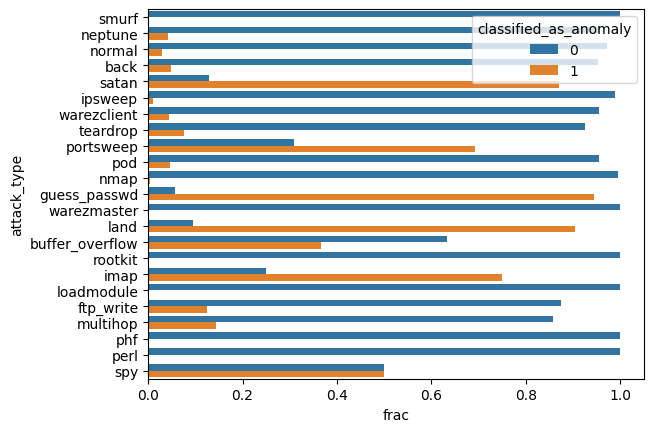

In [80]:
sns.barplot(data=merged, x="frac", y="attack_type", hue="classified_as_anomaly")

In the graph above we see how correct and wrong predictions are spread across different attack types. Notice that the results are normalized by the number of instances for that attack, so the blue and orange lines for each attack sum to 1.

Moreover, notice that at this stage of modelling we are not interested in detecting attacks of type neptune and smurf as we are going to use a separate model for that.

From the graph above we notice that the model is making relatively few false positives (around 3% of normal connections are classified as anomalies). Moreover the model is able to detect certain attack types better than others, for example it does very good on preventing the attack type `satan` and `guess_password` but it completely fails in detecting attacks like `ipsweep`. In a future development we might decide to improve the model with a model that is more specialized on those attack types.